### This notebook will load the individual connectivty weights and analyze the `coef_var`

In [1]:
import init_paths
import cortico_cereb_connectivity.globals as gl
import cortico_cereb_connectivity.run_model as rm
import Functional_Fusion.dataset as fdata
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def load_coef_var(train_types):
    var_dic = {'eval_subj': [],
            'coef_var': [],
            'logalpha': [],
            'eval_dataset': [],
            'coef_norm': []}
    for dataset_name, (train_ses, eval_ses, la) in train_types.items():
        config = rm.get_eval_config(eval_dataset=dataset_name, eval_ses=eval_ses, model='ind', cerebellum='MNISymC3', add_rest=True)
        dataset = fdata.get_dataset_class(gl.base_dir, dataset=dataset_name)
        config["subj_list"] = dataset.get_participants().participant_id

        dirname=[]
        mname=[]
        for a in la:
            dirname.append(f"{dataset_name}_CondHalf_{train_ses}_run-all_Icosahedron1002_L2reg")
            mname.append(f"{dataset_name}_CondHalf_{train_ses}_run-all_Icosahedron1002_L2reg_A{a}")

        fm,_ = rm.get_fitted_models(dirname,mname,config)
        for a, alpha in enumerate(la):
            for conn_model in fm[a]:
                var_dic['coef_var'].append(np.nanmean(conn_model.coef_var))
                var_dic['coef_norm'].append(np.linalg.norm(np.nan_to_num(conn_model.coef_), ord='fro'))
            var_dic['eval_subj'].extend(config["subj_list"])
            var_dic['logalpha'].extend([alpha]*(len(var_dic['coef_var'])-len(var_dic['logalpha'])))
        var_dic['eval_dataset'].extend([dataset_name]*(len(var_dic['coef_var'])-len(var_dic['eval_dataset'])))

    var_df = pd.DataFrame(var_dic)
    var_df['subj_id'] = var_df['eval_subj']
    var_df['train_dataset'] = var_df['eval_dataset']
    var_df['effective_weight'] = var_df['coef_norm'] / var_df['coef_var']
    return var_df

In [3]:
logalpha_list = [8, 10]
train_types = {
    'MDTB':        ('ses-s1',     'ses-s2',      logalpha_list),
    'WMFS':        ('ses-01',     'ses-02',      logalpha_list),
    'Nishimoto':   ('ses-01',     'ses-02',      logalpha_list),
}

In [4]:
var_df = load_coef_var(train_types)
var_df.to_csv('/home/ROBARTS/ashahb7/Github/bayes_temp/var_df.tsv', sep='\t', index=False)

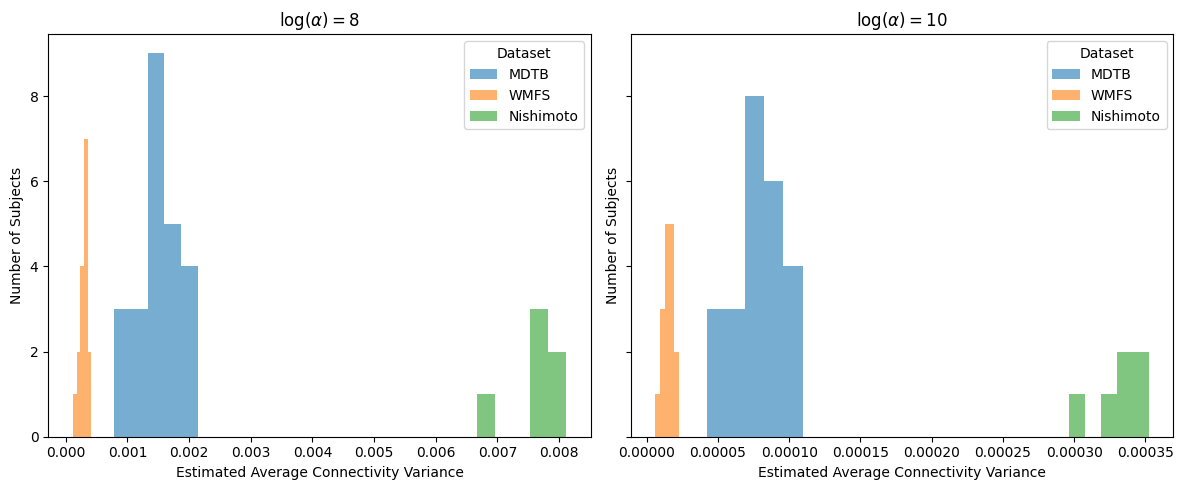

logalpha,8,10
dataset,,
MDTB,2.738153,2.576951
Nishimoto,1.218783,1.189484
WMFS,3.644013,3.871083


logalpha,8,10
variance_width,71.306545,60.133303


In [6]:
var_df = pd.read_csv('/home/ROBARTS/ashahb7/Github/bayes_temp/var_df.tsv', sep='\t')
fig, axes = plt.subplots(1,2,figsize=(12,5), sharey=True)
for i, la in enumerate(var_df.logalpha.unique()):
    ax = axes[i]
    df_to_show = var_df[var_df.logalpha == la]
    for dataset_name in df_to_show.train_dataset.unique():
        ax.hist(df_to_show[df_to_show.train_dataset == dataset_name].coef_var, bins=5, alpha=0.6, label=dataset_name)
    ax.set_xlabel('Estimated Average Connectivity Variance')
    ax.set_ylabel('Number of Subjects')
    ax.legend(title='Dataset')
    ax.set_title(r'$\log(\alpha)={}$'.format(la))
plt.tight_layout()
plt.show()

dataset_variance_widths = var_df.groupby(['logalpha', 'train_dataset'])['coef_var'].apply(lambda x: x.max() / x.min()).reset_index()
dataset_variance_widths.columns = ['logalpha', 'dataset', 'variance_width']
display(dataset_variance_widths.pivot(index='dataset', columns='logalpha', values='variance_width'))

variance_widths = var_df.groupby(['logalpha'])['coef_var'].apply(lambda x: x.max() / x.min()).reset_index()
variance_widths.columns = ['logalpha', 'variance_width']
display(variance_widths.set_index('logalpha').T)

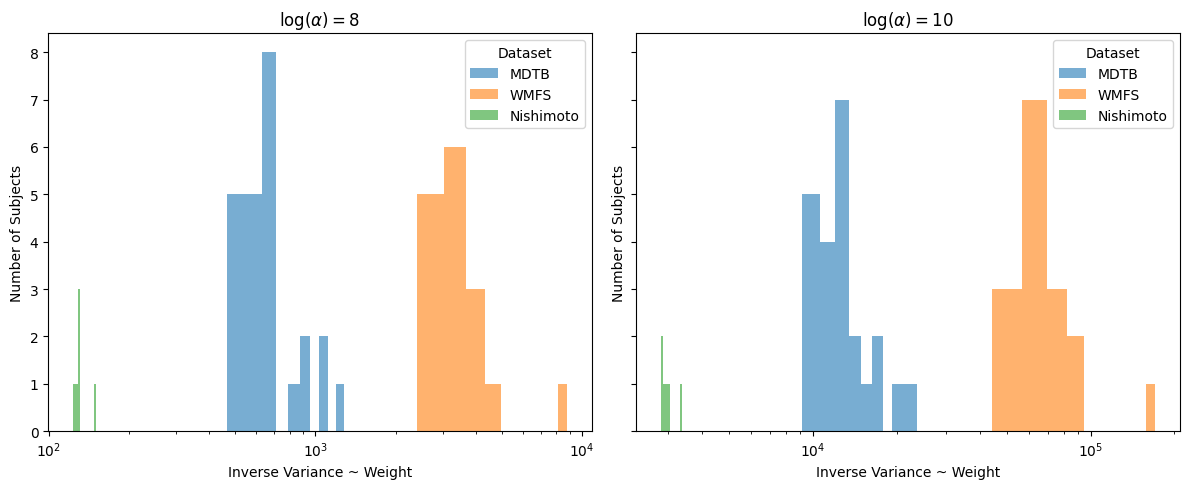

In [19]:
fig, axes = plt.subplots(1,2,figsize=(12,5), sharey=True)
for i, la in enumerate(var_df.logalpha.unique()):
    ax = axes[i]
    df_to_show = var_df[var_df.logalpha == la]
    for dataset_name in df_to_show.train_dataset.unique():
        ax.hist(1/df_to_show[df_to_show.train_dataset == dataset_name].coef_var, alpha=0.6, label=dataset_name)
    ax.set_xlabel('Inverse Variance ~ Weight')
    ax.set_ylabel('Number of Subjects')
    ax.legend(title='Dataset')
    ax.set_title(r'$\log(\alpha)={}$'.format(la))
    ax.set_xscale('log')
plt.tight_layout()
plt.show()

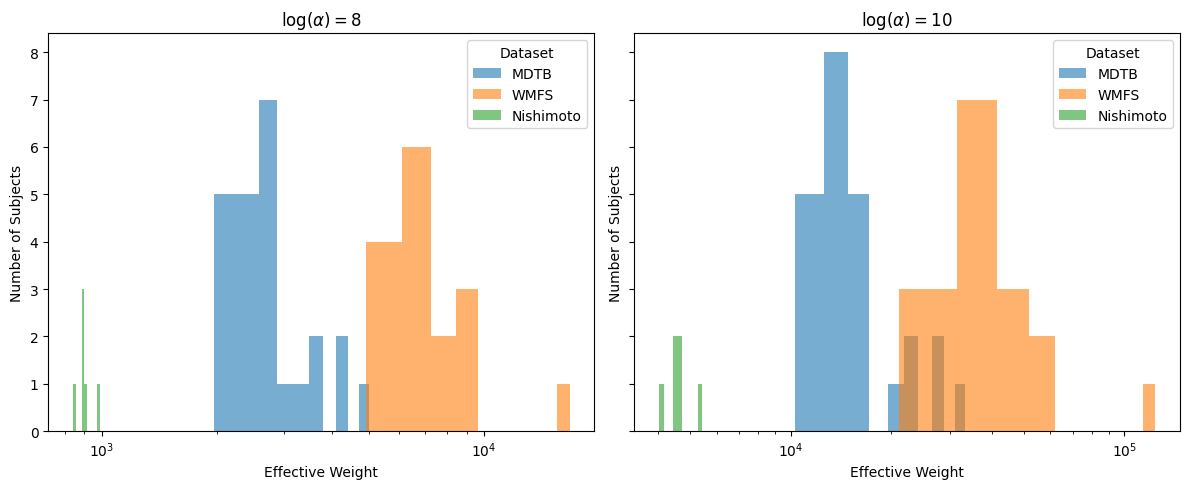

logalpha,8,10
dataset,,
MDTB,2.544091,3.242529
Nishimoto,1.175794,1.349897
WMFS,3.403010,5.842877


logalpha,8,10
weight_width,19.904294,30.749602


In [21]:
fig, axes = plt.subplots(1,2,figsize=(12,5), sharey=True)
for i, la in enumerate(var_df.logalpha.unique()):
    ax = axes[i]
    df_to_show = var_df[var_df.logalpha == la]
    for dataset_name in df_to_show.train_dataset.unique():
        ax.hist(df_to_show[df_to_show.train_dataset == dataset_name].effective_weight, alpha=0.6, label=dataset_name)
    ax.set_xlabel('Effective Weight')
    ax.set_ylabel('Number of Subjects')
    ax.legend(title='Dataset')
    ax.set_title(r'$\log(\alpha)={}$'.format(la))
    ax.set_xscale('log')
plt.tight_layout()
plt.show()

dataset_widths = var_df.groupby(['logalpha', 'train_dataset'])['effective_weight'].apply(lambda x: x.max() / x.min()).reset_index()
dataset_widths.columns = ['logalpha', 'dataset', 'weight_width']
display(dataset_widths.pivot(index='dataset', columns='logalpha', values='weight_width'))

weight_widths = var_df.groupby(['logalpha'])['effective_weight'].apply(lambda x: x.max() / x.min()).reset_index()
weight_widths.columns = ['logalpha', 'weight_width']
display(weight_widths.set_index('logalpha').T)